# PARABOLA

In [1]:
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import matplotlib
import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from SensorimotorExploration.DataManager.SimulationData import load_sim_h5_v2 as load_sim_h5
from SensorimotorExploration.DataManager.PlotTools import *

In [3]:
def create_dict(groups_k):
    return {k[0] + '_' + k[1]: [] for k in groups_k}

def incremental_mean(arr_):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(n_samples):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    out = np.array(out).flatten()
    return out

def moving_av(arr_, win_sz):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(win_sz):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    for i in range(win_sz,n_samples):
        sum_ = sum_ + arr_[i] - arr_[i-win_sz]
        out += [sum_/win_sz]
    out = np.array(out).flatten()
    return out

def std_markers(ax,y,m,c,sz):
    import random
    r = lambda: random.randint(0,255)
    color = ('#%02X%02X%02X' % (r(),r(),r()))

    plt.sca(ax)
    plt.hold(True)
    for i,(y_,ms_) in enumerate(zip(y,sz)):
        plt.plot(i, y_, marker = m, ms = ms_, color = color)
   

In [16]:
directory = 'parabola_slope_social_test_random_INSTRUCTOR_2/'
data_files = os.listdir(directory)

n_samples = 25200

# Group by:
mode_ops = ['social']
alpha_social_thresh = ['1_0','0_999999']#,'0_995','0_99','0_985','0_98']

groups1 = itertools.product(alpha_social_thresh, mode_ops)
groups2 = itertools.product(['1'], ['autonomous'])

groups_k =  list(groups2) + list(groups1)

#container for error
means_e = create_dict(groups_k)
means_av_e = create_dict(groups_k)

#container for social error
means_s = create_dict(groups_k)
means_av_s = create_dict(groups_k)

#container for whole evaluation error 
means_w = create_dict(groups_k)
means_av_w = create_dict(groups_k)

#container for interactions social eval
means_inter_s = create_dict(groups_k)
means_inter_av_s = create_dict(groups_k)

#container for interactions whole eval
means_inter_w = create_dict(groups_k)
means_inter_av_w = create_dict(groups_k)

#container for acomulated collisions
coll_e = create_dict(groups_k)
coll_av_e = create_dict(groups_k)

#container for collisions in social evaluation (not used)
coll_s = create_dict(groups_k)
coll_av_s = create_dict(groups_k)

#container for collisions in whole evaluation (not used)
coll_w = create_dict(groups_k)
coll_av_w = create_dict(groups_k)

#container for interactions data 
inter = create_dict(groups_k)
inter_av = create_dict(groups_k)

#container for errors
error_ev = create_dict(groups_k)
error_ev_av = create_dict(groups_k)

#container for standar deviations
std_ev = create_dict(groups_k)

#container for competence during exploration
comp_w = create_dict(groups_k)
comp_av_w = create_dict(groups_k)


for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
    data_file = directory + data_file
    conf_file = data_file.replace('sim_data.h5', 'conf.txt')
    conf = {}
    with open(conf_file) as f:
        for line in f:
            line = line.replace('\n', '')
            (key, val) = line.split(': ')
            conf[key] = val

    #try:
    #    if conf['instructor_slope']=='0.995':
    #        pass
    #except:
    #    conf['instructor_slope']='0.995'
    
    try:
        data,foo = load_sim_h5(data_file)
        interaction_data = data.social.data.as_matrix(columns=None)
        interactions = np.zeros((n_samples,))
        interactions[~np.isnan(interaction_data[:n_samples, 0])] = 1

        social_data, foo = load_sim_h5(data_file.replace('sim_data.h5', 'eval_social_sensor_eva_valset.h5'))
        whole_data, foo = load_sim_h5(data_file.replace('sim_data.h5', 'eval_whole_sensor_eva_valset.h5'))

        s_error_ = np.linalg.norm(social_data.sensor_goal.data.as_matrix() -
                                  social_data.sensor.data.as_matrix(), axis=1)
        
        s_con_v = social_data.cons.data.as_matrix()
    
        
        wh_error_ = np.linalg.norm(whole_data.sensor_goal.data.as_matrix() -
                                  whole_data.sensor.data.as_matrix(), axis=1)

        wh_con_v = whole_data.cons.data.as_matrix()

        e_con_v = data.cons.data.as_matrix()
        
        
        
        error_ = np.linalg.norm(data.sensor_goal.data.as_matrix() -
                                          data.sensor.data.as_matrix(), axis=1)

        error_ss_ = np.linalg.norm(data.somato_goal.data.as_matrix() -
                                  data.somato.data.as_matrix(), axis=1)


        eva_errors = []
        with open(data_file.replace('sim_data.h5', 'eval_error.txt'), 'r') as f:
            for line in f:
                line.replace('\n', '')
                eva_errors_str = line.split(': ')
                eva_errors += [float(eva_errors_str[1])]
                
        if conf['mode'] == 'autonomous':
            conf['instructor_slope'] = '1'
        else:
            conf['instructor_slope'] = conf['instructor_slope'].replace('.','_')
            
        means_s[conf['instructor_slope'] + '_' + conf['mode']] += [np.mean(s_error_)]
        means_w[conf['instructor_slope'] + '_' + conf['mode']] += [np.mean(wh_error_)]

        coll_s[conf['instructor_slope'] + '_' + conf['mode']] += [np.mean(s_con_v)]
        coll_w[conf['instructor_slope'] + '_' + conf['mode']] += [np.mean(wh_con_v)]
        coll_e[conf['instructor_slope'] + '_' + conf['mode']] += [e_con_v[:n_samples]]
        
        
        
        
    
        inter[conf['instructor_slope'] + '_' + conf['mode']] += [interactions]

        error_ev[conf['instructor_slope'] + '_' + conf['mode']] += [eva_errors]

        comp_w[conf['instructor_slope'] + '_' + conf['mode']] += [error_[:n_samples]]
        #wh_comp_w[conf['instructor_slope'] + '_' + conf['mode']] += [error_ss_[:2200]]  
        
    except IOError:
        print("Something went wrong!")

legend = []
max_std = 0
for i, k in enumerate(groups_k):
    print(k)
    group = k[0] + '_' + k[1] 
    legend += [group]

    means_av_s[group] = np.mean(np.array(means_s[group]))
    means_av_w[group] = np.mean(np.array(means_w[group]))

    
    coll_av_s[group] = np.mean(np.array(coll_s[group]), axis=0)
    coll_av_w[group] = np.mean(np.array(coll_w[group]), axis=0)
    coll_av_e[group] = np.mean(np.array(coll_e[group]), axis=0)

    
    inter_av[group] = np.mean(np.array(inter[group]), axis=0)
    
    comp_av_w[group] = np.mean(np.array(comp_w[group]), axis=0)
    #wh_comp_av_w[group] = np.mean(np.array(wh_comp_w[group]), axis=0)
    
    error_ev_av[group] = np.mean(np.array(error_ev[group]), axis=0)
    std_ev[group] = np.std(np.array(error_ev[group]),axis=0)
    max_std = max(max_std,max(std_ev[group].flatten()))
    
    
print(max_std)

('1', 'autonomous')
('1_0', 'social')
('0_999999', 'social')
0.378457980609


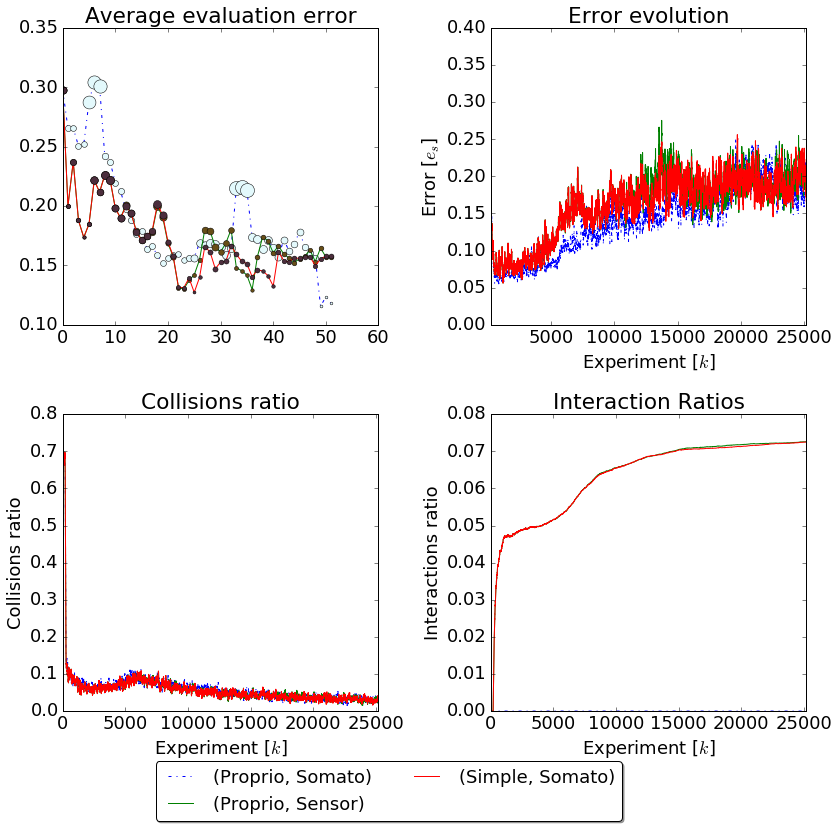

In [17]:
matplotlib.rcParams['figure.figsize'] = (12.0, 11.0)
matplotlib.rcParams.update({'font.size': 18})

#try:
#    del error_ev_av['1_autonomous']
#except:
#    pass

fig1, ax1 = plt.subplots(2,2)
plt.sca(ax1[0,0])
plt.gca().set_color_cycle(None)
ax1[0,0].set_title('Average evaluation error')
#print('Average evaluation error')
plt.hold(True)
for key in error_ev_av.keys():
    data_plt = error_ev_av[key]
    # print("{}: {}".format(key, data_plt[-1]))
    if 'autonomous' in key:
        plt.plot(data_plt, linestyle='-.', marker='')#, color='b')    
    else:
        plt.plot(data_plt, linestyle='-', marker='')#, color='b')
    ms = [(x/max_std)*13 + 1 for x in std_ev[key]]
    std_markers(ax1[0,0],error_ev_av[key],'o','b',ms)
    #print("key: {}, error: {}".format(key, error_ev_av[key][-1]))

    #plt.legend(error_ev_av.keys())


plt.sca(ax1[0,1])
ax1[0,1].set_title('Error evolution')
#print('Error evolution')
win_sz=50
plt.hold(True)
plt.gca().set_color_cycle(None)
for key in error_ev_av.keys():
    data_plt = moving_av(comp_av_w[key],win_sz)
    #print("{}: {}".format(key, data_plt[-1]))
    if 'autonomous' in key:
        plt.plot(data_plt, linestyle='-.', marker='')
    else:
        plt.plot(data_plt, linestyle='-', marker='')
plt.xlabel('Experiment [$k$]')
plt.ylabel('Error [$e_s$]')
# plt.legend(['(Proprio, Social)', '(Proprio, Auto)', '(Simple, Social)', '(Simple, Auto)'],\
#            ncol=2,loc='lower right', fontsize=13)
ax1[0,1].set_xlim([200,n_samples])
ax1[0,1].set_ylim([0,0.4])


plt.sca(ax1[1,0])
ax1[1,0].set_title('Collisions ratio')
#print('Collisions ratio')
plt.hold(True)
plt.gca().set_color_cycle(None)
for key in error_ev_av.keys():
    data_plt = moving_av(coll_av_e[key],win_sz)
    #print("{}: {}".format(key, data_plt[-1]))
    if 'autonomous' in key:
        plt.plot(data_plt, linestyle='-.', marker='')
    else:
        plt.plot(data_plt, linestyle='-', marker='')

plt.xlabel('Experiment [$k$]')
plt.ylabel('Collisions ratio')
lgd = plt.legend(['(Proprio, Somato)', '(Proprio, Sensor)', '(Simple, Somato)', '(Simple, Sensor)'],\
           ncol=2,loc='lower right', fontsize=18, bbox_to_anchor=(1.8, -0.4),
          fancybox=True, shadow=True)
ax1[1,0].set_xlim([0,n_samples])
ax1[1,0].set_ylim([0,0.8])

plt.sca(ax1[1,1])
ax1[1,1].set_title('Interaction Ratios')
#print('Interaction Ratios')
plt.hold(True)
plt.gca().set_color_cycle(None)
for key in error_ev_av.keys():
    data_plt = incremental_mean(inter_av[key])
    #print("{}: {}".format(key, data_plt[-1]))
    if 'autonomous' in key:
        plt.plot(data_plt, linestyle='-.', marker='')
    else:
        plt.plot(data_plt, linestyle='-', marker='')
plt.xlabel('Experiment [$k$]')
plt.ylabel('Interactions ratio')
ax1[1,1].set_xlim([0,n_samples])
ax1[1,1].set_ylim([0,0.08])


plt.tight_layout()

In [18]:
means_av_w

{'0_999999_social': 0.098813897036421475,
 '1_0_social': 0.10425460155783525,
 '1_autonomous': 0.099497031390031673}

In [19]:
means_av_s

{'0_999999_social': 0.15774504345797763,
 '1_0_social': 0.15716171570886545,
 '1_autonomous': 0.11798743987628732}

In [ ]:
#fig1.savefig('/home/yumilceh/Desktop/parabola_results_4.eps',\
#             format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
error_ev_av['0_84_social']

In [10]:
coll_av_s

{'1_autonomous': 0.10625}

In [26]:
directory

'parabola_slope_social_thresh_final_4/'